Setting up the Time Series

In [1]:
#import dependencies
import pandas as pd
from pandas import datetime
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
from numpy import log

In [2]:
#read in csv containing countries involved in the Holocaust (countries provided by the United States Holocaust Museaum)
csv = "CountryCleanedMET.csv"

full_data = pd.read_csv(csv)

#reduce dataframe to just the object number (unique per piece) and year the Met acquired the piece
year_acq = full_data[["Object Number", "AccessionYear"]]

year_acq.head()

C:\Users\lksh0\anaconda3\envs\PythonAdv\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (3,17,24,25,26,27) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Object Number,AccessionYear
0,1976.246.1,1976
1,1976.246.2,1976
2,"1976.246.3a, b",1976
3,1976.246.4,1976
4,1978.291.2,1978


In [3]:
#group the pieces by year acquired
year_acq_group = year_acq.groupby("AccessionYear").count()

year_acq_group


,Object Number
AccessionYear,
1870,1
1872,3
1873,65
1874,4731
1875,47
...,...
2016,404
2017,880
2018,1328


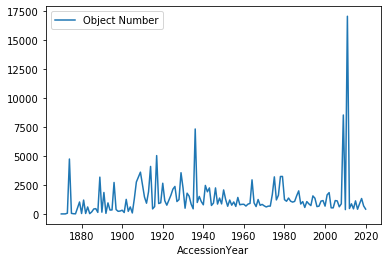

In [4]:
#plot the data as a time series - years on X and number of items acquired on Y
year_acq_group.plot()
pyplot.show()

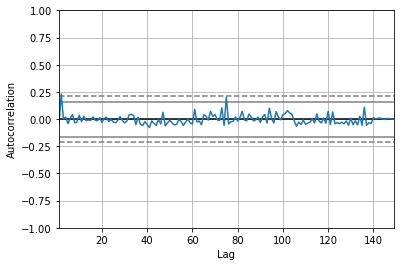

In [5]:
#plot the autocorrelation for lags in time series
autocorrelation_plot(year_acq_group)
pyplot.show()

#positive trend for the first approx 5 lags.  Start AR param at 2

Create the ARIMA model

In [6]:
#import additional dependencies
from statsmodels.tsa.arima.model import ARIMA
from pandas import DataFrame

In [7]:
#fit the model using year_acq_group data
model = ARIMA(year_acq_group, order=(1,1,1))
model_fit = model.fit()

#summary of the fit model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:          Object Number   No. Observations:                  149
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1319.224
Date:                Sun, 28 Feb 2021   AIC                           2644.448
Time:                        13:00:41   BIC                           2653.439
Sample:                             0   HQIC                          2648.101
                                - 149                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0880      0.189     -0.467      0.641      -0.458       0.282
ma.L1         -0.9450      0.041    -22.853      0.000      -1.026      -0.864
sigma2      3.197e+06   1.32e+05     24.265      0.0

C:\Users\lksh0\anaconda3\envs\PythonAdv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\lksh0\anaconda3\envs\PythonAdv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\lksh0\anaconda3\envs\PythonAdv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


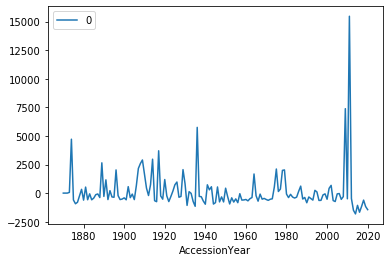

In [8]:
# Plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()

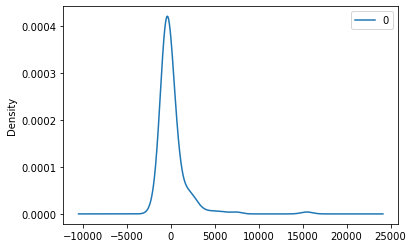

In [9]:
#density plot of the residuals
residuals.plot(kind='kde')
pyplot.show()

In [10]:
#summary stats of residuals
print(residuals.describe())

                  0
count    149.000000
mean     154.655395
std     1789.264440
min    -1818.982354
25%     -595.553276
50%     -336.464962
75%      288.421771
max    15472.833154


Test/Train datasets

In [11]:
#create test and train datasets
X = year_acq_group.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [X for X in train]
predictions = list()

In [20]:
#walk-forward validation
for t in range(len(test)):
    model = ARIMA (history, order=(0,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=1619.171664, expected=696.000000
predicted=1356.268876, expected=601.000000
predicted=1350.817136, expected=672.000000
predicted=1346.140207, expected=674.000000
predicted=1341.130460, expected=1674.000000
predicted=1343.306770, expected=3193.000000
predicted=1356.166196, expected=1208.000000
predicted=1354.836870, expected=1605.000000
predicted=1356.524854, expected=3225.000000
predicted=1589.352459, expected=3229.000000
predicted=1658.954734, expected=1230.000000
predicted=1638.528913, expected=1093.000000
predicted=1613.060113, expected=1368.000000
predicted=1603.765535, expected=1101.000000
predicted=1584.439216, expected=1019.000000
predicted=1563.005769, expected=1080.000000
predicted=1372.604077, expected=1567.000000
predicted=1373.810658, expected=1986.000000
predicted=1560.705978, expected=853.000000
predicted=1374.463404, expected=1063.000000
predicted=1371.830534, expected=559.000000
predicted=1366.844900, expected=1063.000000
predicted=1364.805622, expected=869.00

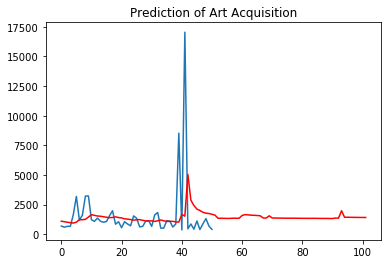

In [22]:
#plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.title("Prediction of Art Acquisition")
#pyplot.savefig("prediction.png")
pyplot.show()

<Figure size 432x288 with 0 Axes>